# DECALS

In [1]:
from datasets import load_dataset, concatenate_datasets
import argparse
from ddpm.denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer, Galaxies
import wandb
import torch
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%load_ext autoreload
%autoreload 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import datasets
datasets.__version__

'2.18.0'

In [4]:
# meta data
metadata = load_dataset("parquet", data_files="/pscratch/sd/s/sihany/smithgalaxies/galaxies/metadata.parquet", split="train")
meta_sorted = metadata.sort("dr8_id")
# meta_sorted = meta_sorted.with_format("torch", device=DEVICE)


ds = load_dataset("parquet", data_files={'train': '/pscratch/sd/s/sihany/smithgalaxies/galaxies/data/train*'}, split="train[:12%]")

ds = ds.sort("dr8_id")
# ds = ds.with_format("torch", device=DEVICE)
print(len(ds))
ids_train = set(ds['dr8_id'])
meta_train = meta_sorted.filter(lambda example: example["dr8_id"] in ids_train, num_proc = 4)
assert len(meta_train['dr8_id']) == len(ds['dr8_id'])
assert meta_train['dr8_id'] == ds['dr8_id']


# select only rows with good specz
inds = [example is not None for example in meta_train['spec_z']]
import numpy as np
inds = np.arange(len(meta_train))[np.array(inds)]

ds = ds.select(inds)
meta_train = meta_train.select(inds)

# merge datasets
ds = concatenate_datasets([ds, meta_train.select_columns(['spec_z', 'mass_inf_photoz', 'sfr_inf_photoz'])], axis = 1)

(array([4.8993e+04, 4.6566e+04, 1.8758e+04, 1.2905e+04, 1.5570e+03,
        5.6000e+01, 5.0000e+00, 4.0000e+00, 5.0000e+00, 3.5000e+01]),
 array([1.14445240e-04, 1.07403001e-01, 2.14691556e-01, 3.21980112e-01,
        4.29268667e-01, 5.36557223e-01, 6.43845778e-01, 7.51134334e-01,
        8.58422889e-01, 9.65711445e-01, 1.07300000e+00]),
 <BarContainer object of 10 artists>)

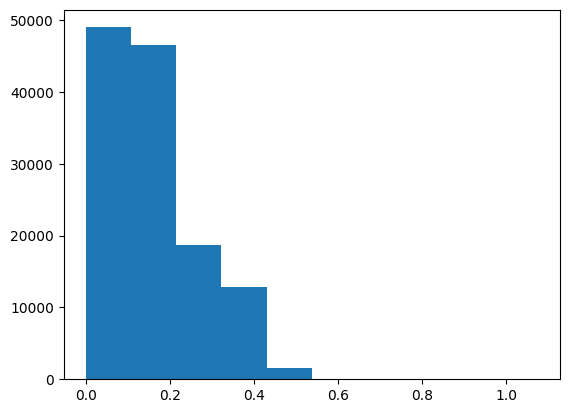

In [29]:
import matplotlib.pyplot as plt
plt.hist(ds['spec_z'])

In [31]:
from torchvision import transforms

# Preprocessing the datasets and DataLoaders creation.
augmentations = transforms.Compose(
    [
            transforms.CenterCrop((128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
    ]
)

def transform_images(examples):
    images = [augmentations(image.convert("RGB")) for image in examples["image"]]
    return {"image": images, "dr8_id": examples['dr8_id'], "spec_z": examples['spec_z'], 
            "mass_inf_photoz": examples['mass_inf_photoz'], "sfr_inf_photoz": examples['sfr_inf_photoz']}

ds.set_transform(transform_images)

# send to cuda
ds = ds.with_format("torch", device=DEVICE)

# HSC

In [48]:
from datasets import load_dataset

dset = load_dataset('/pscratch/sd/s/sihany/multimodal_universe/hsc', 
                    split='train', streaming=True)

In [23]:
dset = dset.with_format('numpy')

In [62]:
example = next(iter(dset))

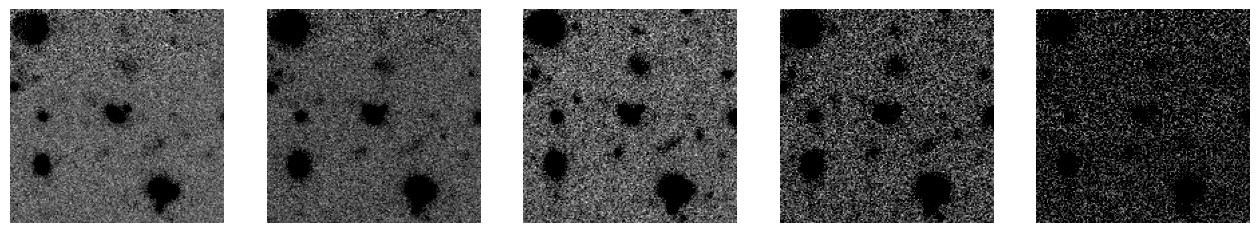

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(example['image']['band']), figsize=(16, 4))
for i, b in enumerate(example['image']['band']):
    axs[i].imshow(example['image']['array'][i],vmax=0.1, cmap='gray_r')
    axs[i].set_axis_off()
fig.show()



In [97]:
from PIL import Image
import numpy as np


def arrays_to_pil_image(example):
    blue_channel = example['image']['array'][0]
    green_channel = example['image']['array'][1]
    red_channel = example['image']['array'][3]
    # Ensure the input arrays have the same shape
    assert red_channel.shape == green_channel.shape == blue_channel.shape, "All input arrays must have the same shape"
    
    # Stack the arrays along the third dimension
    stacked_array = np.stack((red_channel, green_channel, blue_channel), axis=-1)
    
    # Convert to a PIL image
    pil_image = Image.fromarray(stacked_array.astype(np.uint8))
    
    return pil_image

image = arrays_to_pil_image(example)

In [98]:
dset_images = [arrays_to_pil_image(example) for example in iter(dset)]

KeyboardInterrupt: 

In [66]:
# test dataloader
from torchvision import transforms

def transform(examples):
    preprocess = transforms.Compose(
        [
            # transforms.Resize((config.image_size, config.image_size)),
            # transforms.CenterCrop((config.image_size, config.image_size)),
            
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )
    
    images = [preprocess(transforms.ToPILImage(example["image"]['array'])) for example in examples]
    return {"images": images}

transform(iter(dset))


TypeError: img should be PIL Image. Got <class 'torchvision.transforms.transforms.ToPILImage'>

# JWST

In [1]:
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits 
from glob import glob

# load in all our images and WCSs    
images = {}
wcs = {}
photflam = {}
photplam = {}
myfilters = np.array(['f070w', 'f090w', 'f115w', 'f140m', 'f150w', 'f162m', 'f182m', 'f200w', 'f210m', 
                    'f250m', 'f277w', 'f300m', 'f335m', 'f360m', 'f356w', 'f410m', 'f430m', 'f444w', 'f460m', 'f480m'])
# myfilters = np.array(['f070w', 'f090w', 'f115w', 'f140m', 'f150w','f200w', 'f277w', 'f356w', 'f410m', 'f444w'])
filters_sw = np.array(['f070w', 'f090w', 'f115w', 'f140m', 'f150w', 'f162m', 'f182m', 'f200w', 'f210m']) # these have 0.02" pixel scale (LW = 0.04")
for f in myfilters:
    print(f)
    fname = glob('/pscratch/sd/s/sihany/UNCOVER/uncover_v5.2.0_abell2744clu*'+f+'*.fits.gz')
    with fits.open(fname[0]) as hdu:
        images[f] = hdu[0].data
        wcs[f] = WCS(hdu[0].header)
        photflam[f] = hdu[0].header['PHOTFLAM']
        photplam[f] = hdu[0].header['PHOTPLAM']

f070w
f090w
f115w
f140m
f150w
f162m
f182m
f200w
f210m
f250m
f277w
f300m
f335m
f360m
f356w
f410m
f430m
f444w
f460m
f480m


In [2]:
from astropy.visualization import make_lupton_rgb

def _rebin(arr, new_2dshape):
    # shape = (new_2dshape[0], arr.shape[0] // new_2dshape[0],
    #          new_2dshape[1], arr.shape[1] // new_2dshape[1])
    # print(arr.shape, shape)
    # Calculate the trimming size if dimensions are not divisible
    trim_shape = (arr.shape[0] - arr.shape[0] % new_2dshape[0],
                  arr.shape[1] - arr.shape[1] % new_2dshape[1])

    # Trim the array if necessary
    arr_trimmed = arr[:trim_shape[0], :trim_shape[1]]
    
    # Now rebin the trimmed array
    shape = (new_2dshape[0], arr_trimmed.shape[0] // new_2dshape[0],
             new_2dshape[1], arr_trimmed.shape[1] // new_2dshape[1])
    
    return arr_trimmed.reshape(shape).sum(-1).sum(-2)

def get_cutout(x, y, dt, im):     
    """
    make a cutout of an image "im" centered at pixel x/y with size dt
    """
    il = np.maximum(0,int(y)-(dt+1))
    iu = np.minimum(int(y)+(dt+1), im.shape[0])
    jl = np.maximum(0,int(x)-(dt+1))
    ju = np.minimum(int(x)+(dt+1), im.shape[1])
    return im[il:iu, jl:ju] 
    
def get_all_cutouts(ra, dec, dt=50):
    allcuts = []
    for f in myfilters:  
        x, y = wcs[f].wcs_world2pix([ra], [dec], 1)  
        if f in filters_sw:
            bigcut = get_cutout(x[0], y[0], dt*2+1, images[f])
            binned = _rebin(bigcut, (int(bigcut.shape[0]/2),
                                            int(bigcut.shape[1]/2)))
            allcuts.append(binned)
        else:    
            allcuts.append(get_cutout(x[0], y[0], dt, images[f]))
    return np.array(allcuts)  


def make_colorim_gabe(cuts, rgb_scl=None, scl=4, pl=1, pf=1, rgb_min=-0.018, whichfil='bb', stretch=0.1, Q=10):
    # broad-band image
    if whichfil == 'bb':
        bfil = 'f115w'; gfil='f277w'; rfil='f444w'
        if rgb_scl is None: rgb_scl = [1.5,.8,1]
        b = cuts[myfilters==bfil][0]; g = cuts[myfilters==gfil][0]; r = cuts[myfilters==rfil][0]
        
        rimg = r * (photflam[rfil]/5.e-20)**pf
        rimg *= (photplam[rfil]/1.e4)**pl*scl*rgb_scl[0]
    
        gimg = g * (photflam[gfil]/5.e-20)**pf
        gimg *= (photplam[gfil]/1.e4)**pl*scl*rgb_scl[1]
    
        bimg = b * (photflam[bfil]/5.e-20)**pf
        bimg *= (photplam[bfil]/1.e4)**pl*scl*rgb_scl[2]
        
        image = make_lupton_rgb(rimg*rgb_scl[0], gimg*rgb_scl[1], bimg*rgb_scl[2], stretch=stretch, Q=8, minimum=rgb_min)
        return image
        
        # bimg = cuts[filters=='f070w'][0]*(photflam['f070w']/5.e-20)**pf * (photplam['f070w']/1.e4)**pl*scl \
        #     +cuts[filters=='f090w'][0]*(photflam['f090w']/5.e-20)**pf * (photplam['f090w']/1.e4)**pl*scl\
        #     +cuts[filters=='f115w'][0] *(photflam['f115w']/5.e-20)**pf * (photplam['f115w']/1.e4)**pl*scl
        #
        # gimg = cuts[filters=='f150w'][0]*(photflam['f150w']/5.e-20)**pf * (photplam['f150w']/1.e4)**pl*scl\
        #     +cuts[filters=='f200w'][0]*(photflam['f200w']/5.e-20)**pf * (photplam['f200w']/1.e4)**pl*scl\
        #     +cuts[filters=='f277w'][0]*(photflam['f277w']/5.e-20)**pf * (photplam['f277w']/1.e4)**pl*scl
        #
        # rimg = cuts[filters=='f356w'][0]*(photflam['f356w']/5.e-20)**pf * (photplam['f356w']/1.e4)**pl*scl+\
        #     cuts[filters=='f444w'][0]*(photflam['f444w']/5.e-20)**pf * (photplam['f444w']/1.e4)**pl*scl
        #
        # image = make_lupton_rgb(rimg*rgb_scl[0], gimg*rgb_scl[1], bimg*rgb_scl[2], stretch=stretch, Q=Q, minimum=rgb_min)
        # return image
        
    # MB image    
    if whichfil == '1um':
        bfil = 'f140m'; gfil='f162m'; rfil='f182m'
        if rgb_scl is None: rgb_scl = [1,1.01,1.01]
    elif whichfil == '2um':
        bfil = 'f210m'; gfil='f250m'; rfil='f300m'
        if rgb_scl is None: rgb_scl = [1,1.01,1.15]
    elif whichfil == '3um':
        bfil = 'f335m'; gfil='f360m'; rfil='f410m' 
        if rgb_scl is None: rgb_scl = [1.1,0.92,1.01]   
    elif whichfil == '4um':
        bfil = 'f430m'; gfil='f460m'; rfil='f480m' 
        if rgb_scl is None: rgb_scl = [1.01,1.01,1]   
        
    else:
        print('oh no! pick the right filter combo.')
        return None        
    
    b = cuts[myfilters==bfil][0]; g = cuts[myfilters==gfil][0]; r = cuts[myfilters==rfil][0]
    
    rimg = r * (photflam[rfil]/5.e-20)**pf
    rimg *= (photplam[rfil]/1.e4)**pl*scl*rgb_scl[0]
    
    gimg = g * (photflam[gfil]/5.e-20)**pf
    gimg *= (photplam[gfil]/1.e4)**pl*scl*rgb_scl[1]
    
    bimg = b * (photflam[bfil]/5.e-20)**pf
    bimg *= (photplam[bfil]/1.e4)**pl*scl*rgb_scl[2]
    
    image = make_lupton_rgb(rimg, gimg, bimg, stretch=stretch, Q=Q, minimum=rgb_min)
    return image
    
def plot_colorim_gabe(cuts, id=None, zspec=None, rgb_1um=[.95,.92,.9], rgb_2um=[1.35,.92,.72], rgb_3um=[1.2,1,.95], 
    rgb_4um=[1,1,.9], stretch=0.08, Q=8, rgb_bb=[1.6,.92,.73], rgb_min=-0.005, whichlines=[0, 1, 2, 3, 4, 5, 6, 7, 8]):
    
    f, ax = plt.subplots(1,5,figsize=(12,6), sharex=True, sharey=True)  
    f.subplots_adjust(wspace=0.05, hspace=0.05)
    
    ax[0].imshow(make_colorim_gabe(cuts, whichfil='bb', rgb_scl=rgb_bb, rgb_min=0, stretch=stretch, Q=Q), origin='lower')
    ax[0].set_title('broad-band', fontsize=10)  
    
    # 140 / 162 / 182
    ax[1].imshow(make_colorim_gabe(cuts, rgb_scl=rgb_1um, whichfil='1um', stretch=stretch, Q=Q, rgb_min=rgb_min), origin='lower')
    ax[1].set_title('F140M / F162M / F182M', fontsize=10)
    
    # 210 / 250 / 300
    ax[2].imshow(make_colorim_gabe(cuts, rgb_scl=rgb_2um, whichfil='2um', stretch=stretch, Q=Q, rgb_min=rgb_min), origin='lower')
    ax[2].set_title('F210M / F250M / F300M', fontsize=10)
    
    # 335 / 360 / 410
    ax[3].imshow(make_colorim_gabe(cuts, rgb_scl=rgb_3um, whichfil='3um', stretch=stretch, Q=Q, rgb_min=rgb_min), origin='lower')
    ax[3].set_title('F335M / F360M / F410M', fontsize=10)
    
    # 430 / 460 / 480      
    ax[4].imshow(make_colorim_gabe(cuts, rgb_scl=rgb_4um, whichfil='4um', stretch=stretch, Q=Q, rgb_min=rgb_min), origin='lower')
    ax[4].set_title('F430M / F460M / F480M', fontsize=10)
    
    # put major lines
    rgb_col = ['steelblue', 'darkgreen', 'firebrick']
    pos = [.05, .3, .55]
    if zspec is not None:
        linewl_redshifted = lines[:,1].astype(float)*(1+zspec)/1e4
        for ii in range(len(lines)):
            if ii not in whichlines: continue
            lineinfil = [key for key, value in filter_wavelengths.items() if value[0]<=linewl_redshifted[ii]<=value[1]]
            if len(lineinfil) == 1:
                thisax = np.where(mb_filters==lineinfil[0].lower())[0][0]//3 + 1
                thislinei = np.where(mb_filters==lineinfil[0].lower())[0][0]%3
                ax[thisax].text(pos[thislinei], 0.025, lines[ii][0], color=rgb_col[thislinei], transform=ax[thisax].transAxes,
                    bbox={'facecolor':'white', 'alpha':0.1, 'edgecolor':'None'}, fontsize=12)
                        
                
    # put a title with ID        
    if id is not None:
        ax[0].set_ylabel(id) 
    ax[0].set_xticks([])
    ax[0].set_yticks([])    
    
    # 0.5" scalebar
    dt = cuts[-1].shape[0]
    ax[0].plot([dt-dt/20, dt-dt/20-(0.5/0.04)], [dt/20, dt/20], color='0.8', lw=2)
           
    return (f, ax)
        
           

In [3]:
from astropy.io import fits 

data = fits.open("/pscratch/sd/s/sihany/UNCOVER/UNCOVER_v5.2.0_LW_SUPER_SPScatalog_spsv0.1.fits")


In [4]:
data[1].data[10]

(11, 3.6006505127594246, -30.46728320030498, 0, 0.32, 1, 999999, 999999, 16959, nan, 1.9609330485158996, 0.5999264816178476, 1.583022589941908, 4.751612477112533, 6.456116531352285, 7.076607220499378, 7.575723235216502, 6.3235584374435545, 6.923106485465148, 7.427150644735454, -1.4628385656188416, -0.7544002677809392, -0.16387566961584066, 0.1375103137585832, 0.9676597113644111, 2.8221763291235007, 0.12428911887529151, 0.4484403633576386, 1.0833816032582262, -0.7260208297122537, -0.24944057956962107, 0.191461981588692, 0.6663582062702927, 0.9433090577864685, 1.23296450065428, -4.031164558740917, -2.24038979509703, -0.604453965281146, 0.00034272587221819637, 0.01054634517817152, 0.18397005506363623, 0.000387444923950372, 0.010791561374006352, 0.18583822066260586, 0.0004978609922979026, 0.011081287909543791, 0.13404654206720723, 4.276453539938005e-11, 6.714059767379735e-10, 7.903927725440884e-09, 4.439894293391879e-11, 6.817577147278075e-10, 7.573932006317536e-09, 6.537249759413562e-11, 

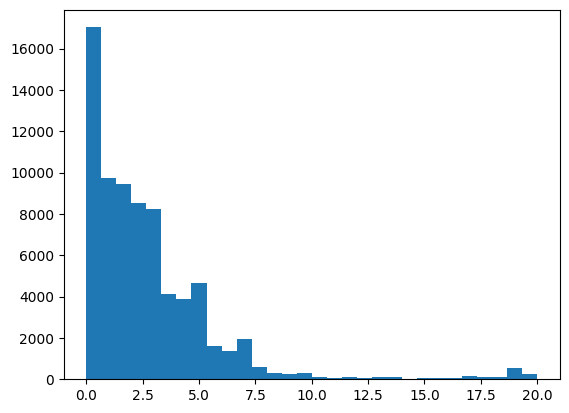

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(data[1].data['z_ml'], bins = 30);

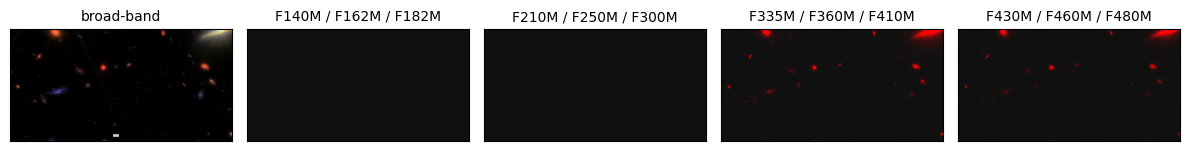

In [6]:
cuts = get_all_cutouts(data[1].data['ra'][10], data[1].data['dec'][10], dt=500)
# get_all_cutouts(3.5541765, -30.3819815, dt=110)
f, ax = plot_colorim_gabe(cuts,whichlines=[])
plt.tight_layout()

In [15]:
# from datasets import load_dataset

# dset = load_dataset('/pscratch/sd/s/sihany/multimodal_universe/jwst', 
#                     split='train', streaming=True)

# dset = dset.with_format('numpy')

# example = next(iter(dset))

# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(1, len(example['image']['band']), figsize=(16, 4))
# for i, b in enumerate(example['image']['band']):
#     axs[i].imshow(example['image']['array'][i],vmax=0.1, cmap='gray_r')
#     axs[i].set_axis_off()
# fig.show()

# this is bugged https://github.com/MultimodalUniverse/MultimodalUniverse/issues/107

In [12]:
# from UNCOVER_mosaics_scripts import scripts_UNCOVER_mosaics

# filters_all_NIRCAM = ['F115W', 'F150W', 'F200W', 'F277W', 'F356W', 'F410M', 'F444W']

# # Non-PSF-matched images:
# path_images = '/pscratch/sd/s/sihany/UNCOVER/'

# filenames_NIRCAM = [path_images+'uncover_v5.2.0_abell2744clu_f115w_bcgs_out_sci.fits.gz',
#                     path_images+'uncover_v5.2.0_abell2744clu_f150w_bcgs_out_sci.fits.gz',
#                     path_images+'uncover_v5.2.0_abell2744clu_f200w_bcgs_out_sci.fits.gz',
#                     path_images+'uncover_v5.2.0_abell2744clu_f277w_bcgs_out_sci.fits.gz',
#                     path_images+'uncover_v5.2.0_abell2744clu_f356w_bcgs_out_sci.fits.gz',
#                     path_images+'uncover_v5.2.0_abell2744clu_f410m_bcgs_out_sci.fits.gz',
#                     path_images+'uncover_v5.2.0_abell2744clu_f444w_bcgs_out_sci.fits.gz']


# upsample=False 

# data_all_NIRCAM = {}

# for filt, fname in zip(filters_all_NIRCAM, filenames_NIRCAM):
#     dattmp = scripts_UNCOVER_mosaics.load_data(fname, filt=filt, upsample=upsample)
#     data_all_NIRCAM[filt] = dattmp
# # Combine filters for the B, G, R images (sum of individual filters)

# filters_RGBsum_NIRCAM=['F115W+F150W', 'F200W+F277W', 'F356W+F410M+F444W']
# dataRGBsum_NIRCAM = scripts_UNCOVER_mosaics.make_dataRGB(data_all=data_all_NIRCAM, 
#                                                          filters=filters_RGBsum_NIRCAM)
# # Free up memory of unnecessary copies of images:
# data_all_NIRCAM = None

In [14]:
# # Calculate scaling factors: 

# cols = ['r', 'g', 'b'] 

# pctl_u = 99.996 

# scale_min_NIRCAM = []
# scale_max_NIRCAM = []

# min_val = 0.

# for col in cols:
#     pctl = np.percentile(dataRGBsum_NIRCAM['{}IMG'.format(col)], pctl_u)
#     scale_min_NIRCAM.append(min_val)
#     scale_max_NIRCAM.append(pctl)
    
# print("scale_min_NIRCAM={}".format(scale_min_NIRCAM))
# print("scale_max_NIRCAM={}".format(scale_max_NIRCAM))

In [15]:
# import matplotlib 

# # Some settings for use with the JupyterNB
# %matplotlib inline
# dpi = 100
# matplotlib.rcParams['figure.dpi']= dpi


# dpi = 100

# # Note: the NIRCAM mosaic with insets is so large that 
# #  Matplotlib cannot save the image with 3600 dpi.

# # Get the settings for this mosaic:
# dict_fieldopts = scripts_UNCOVER_mosaics._get_dict_NIRCAM_primary(dataRGBsum_NIRCAM['rIMG'].shape,
#                                                                 noinsets=False)

# # Get the appropriate size of the moscaic "scaling", 
# # ensuring similar appearance for different DPI images
# plot_scale_inches= dict_fieldopts['rgb_big_shape'][0]/float(1800)

# fout = None

# scripts_UNCOVER_mosaics.plot_full_mosaic_RGB(fileout=fout, data=dataRGBsum_NIRCAM, 
#                        plot_scale_inches=plot_scale_inches, dpi=dpi, 
#                        minimum=scale_min_NIRCAM, maximum=scale_max_NIRCAM, 
#                        scalea=1500, imscale_type='log',
#                        dict_fieldopts=dict_fieldopts)

# DESI 

In [44]:
dataset = load_dataset("imagefolder", data_files={"train": "/pscratch/sd/s/sihany/desiimages/train/**"}, split="train")

Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

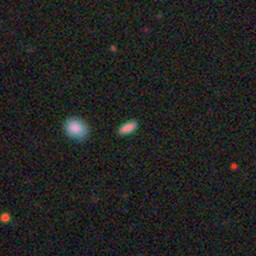

In [70]:
next(iter(dataset))['image'].convert("RGB")

In [21]:
import h5py
from astropy.io.misc import hdf5

In [22]:
f = hdf5.read_table_hdf5('/global/cfs/cdirs/desi/public/edr/vac/edr/provabgs/v1.0/BGS_ANY_full.provabgs.sv3.v0.hdf5')

In [24]:
f.keys()

['TARGETID',
 'RA',
 'DEC',
 'Z_HP',
 'ZERR',
 'TSNR2_BGS',
 'MAG_G',
 'MAG_R',
 'MAG_Z',
 'MAG_W1',
 'FIBMAG_R',
 'HPIX_64',
 'PROVABGS_MCMC',
 'PROVABGS_THETA_BF',
 'PROVABGS_Z_MAX',
 'PROVABGS_LOGMSTAR_BF',
 'PROVABGS_LOGMSTAR',
 'SCHLEGEL_COLOR',
 'PROVABGS_W_ZFAIL',
 'PROVABGS_W_FIBASSIGN',
 'IS_BGS_BRIGHT',
 'IS_BGS_FAINT']